In [2]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib as mpl

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from itertools import product

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

# Идеи для фич

1) лаги/средние/...
2) курс доллара
3) дата налогового дня?
4) праздники
5) время отдыха
6) ...

# Загрузка данных

In [3]:
df = pd.read_excel("/home/owner/Documents/DEV/Time_series/Project 1_2024.xlsx", parse_dates=['Date'], index_col='Date')

In [4]:
df.index.dtype

dtype('<M8[ns]')

# График временного ряда

<Axes: xlabel='Date', ylabel='Balance'>

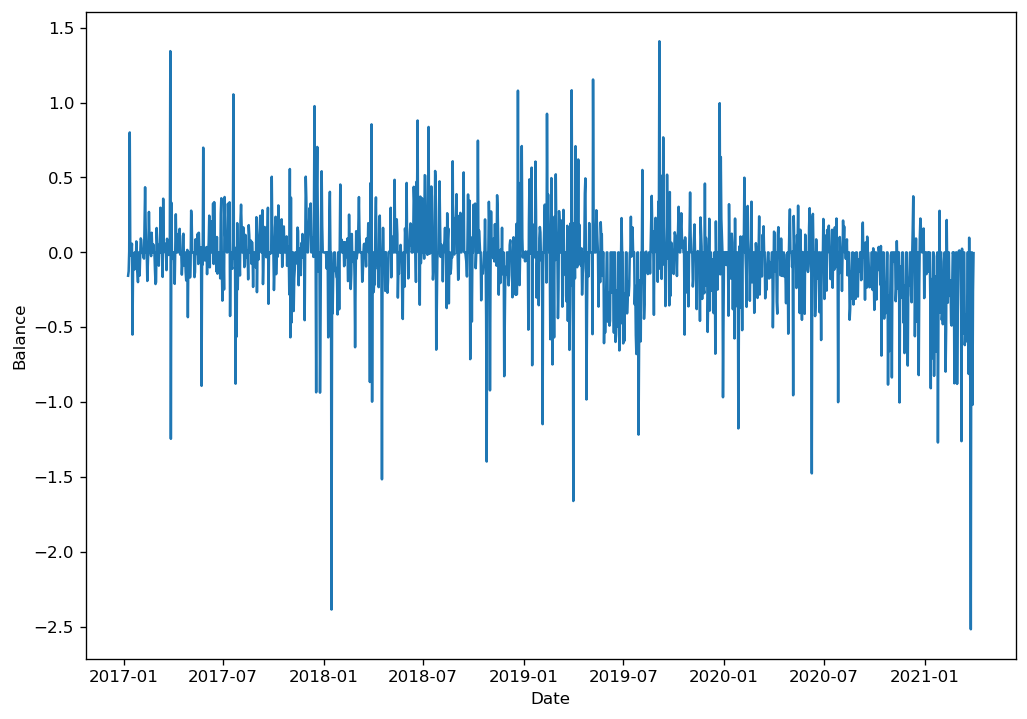

In [5]:
sns.lineplot(x = df.index, y = df.Balance)


# Тест Дики-Фуллера для проверки на стационарность

In [6]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [7]:
adf_test(df.Balance)

Results of Dickey-Fuller Test:
Test Statistic                   -4.114101
p-value                           0.000918
#Lags Used                       20.000000
Number of Observations Used    1522.000000
Critical Value (1%)              -3.434654
Critical Value (5%)              -2.863441
Critical Value (10%)             -2.567782
dtype: float64


In [8]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [9]:
check_stationarity(df.Balance)

ADF Statistic: -4.114101
p-value: 0.000918
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Stationary


# Разложение на компоненты (попытка)

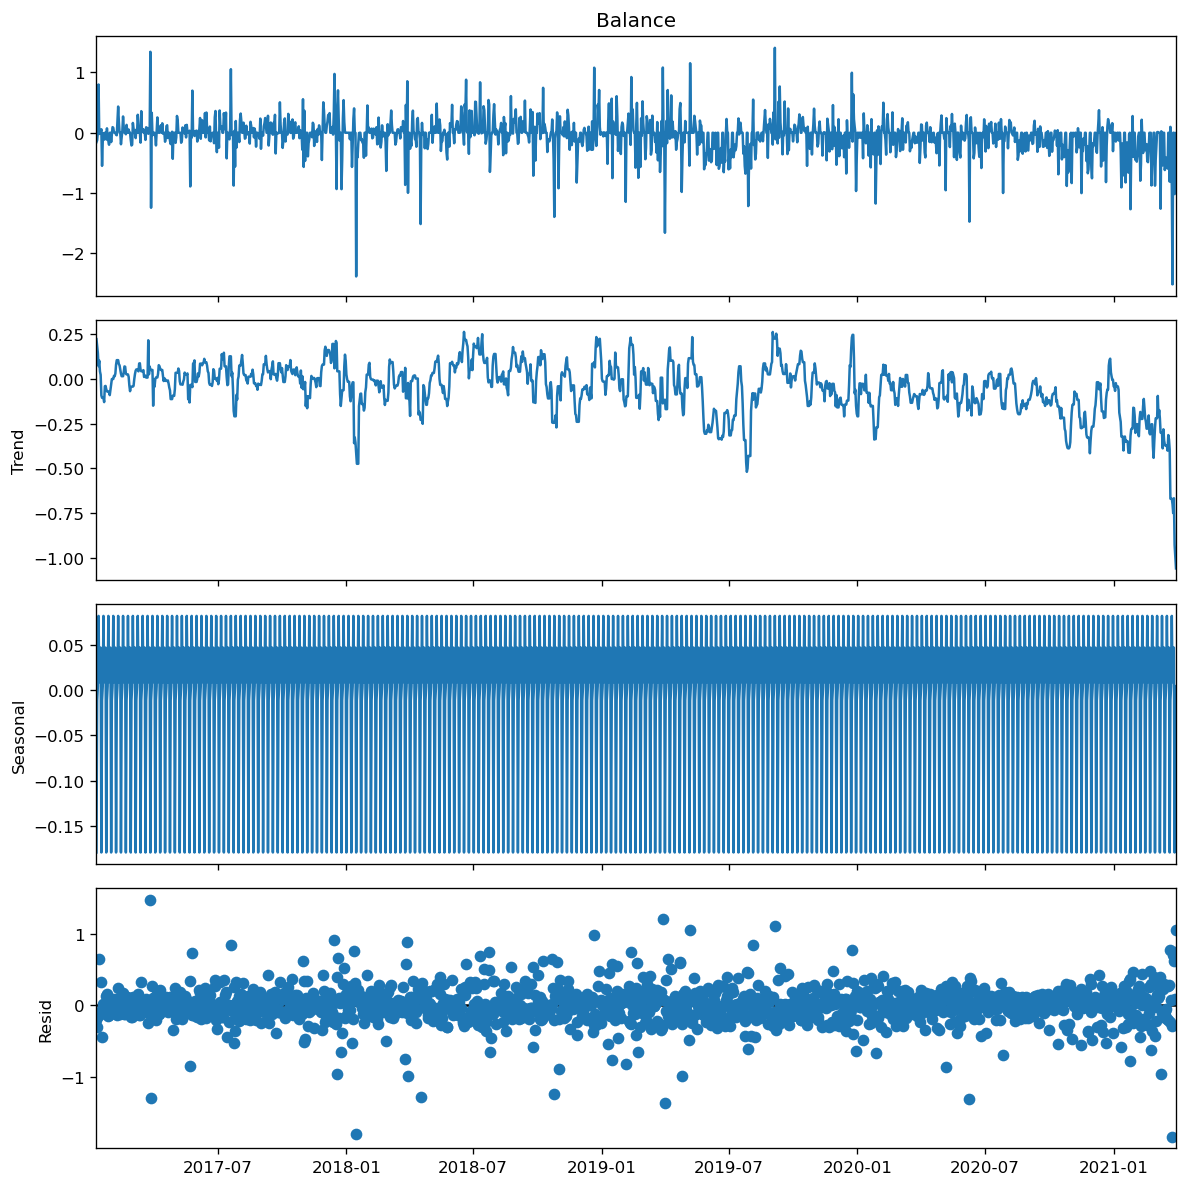

In [10]:
# Additive Decomposition
result_add = seasonal_decompose(df.Balance, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

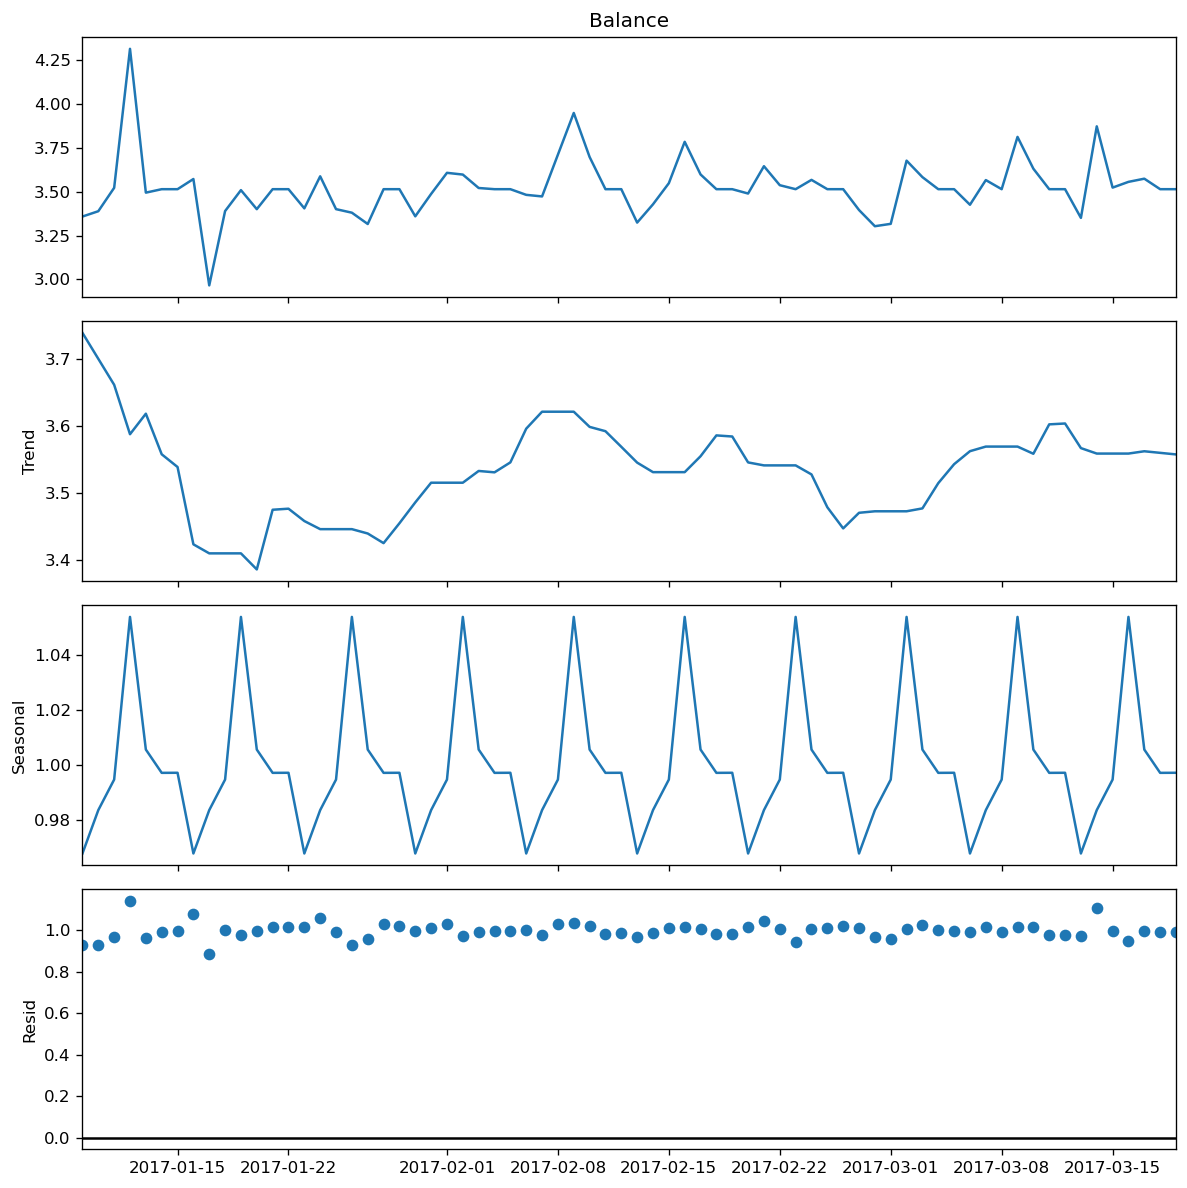

In [51]:
df.posBalance = df.Balance + np.abs(df.Balance.min()) + 1

result_add = seasonal_decompose(df.posBalance[:70], model='multiplicative', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

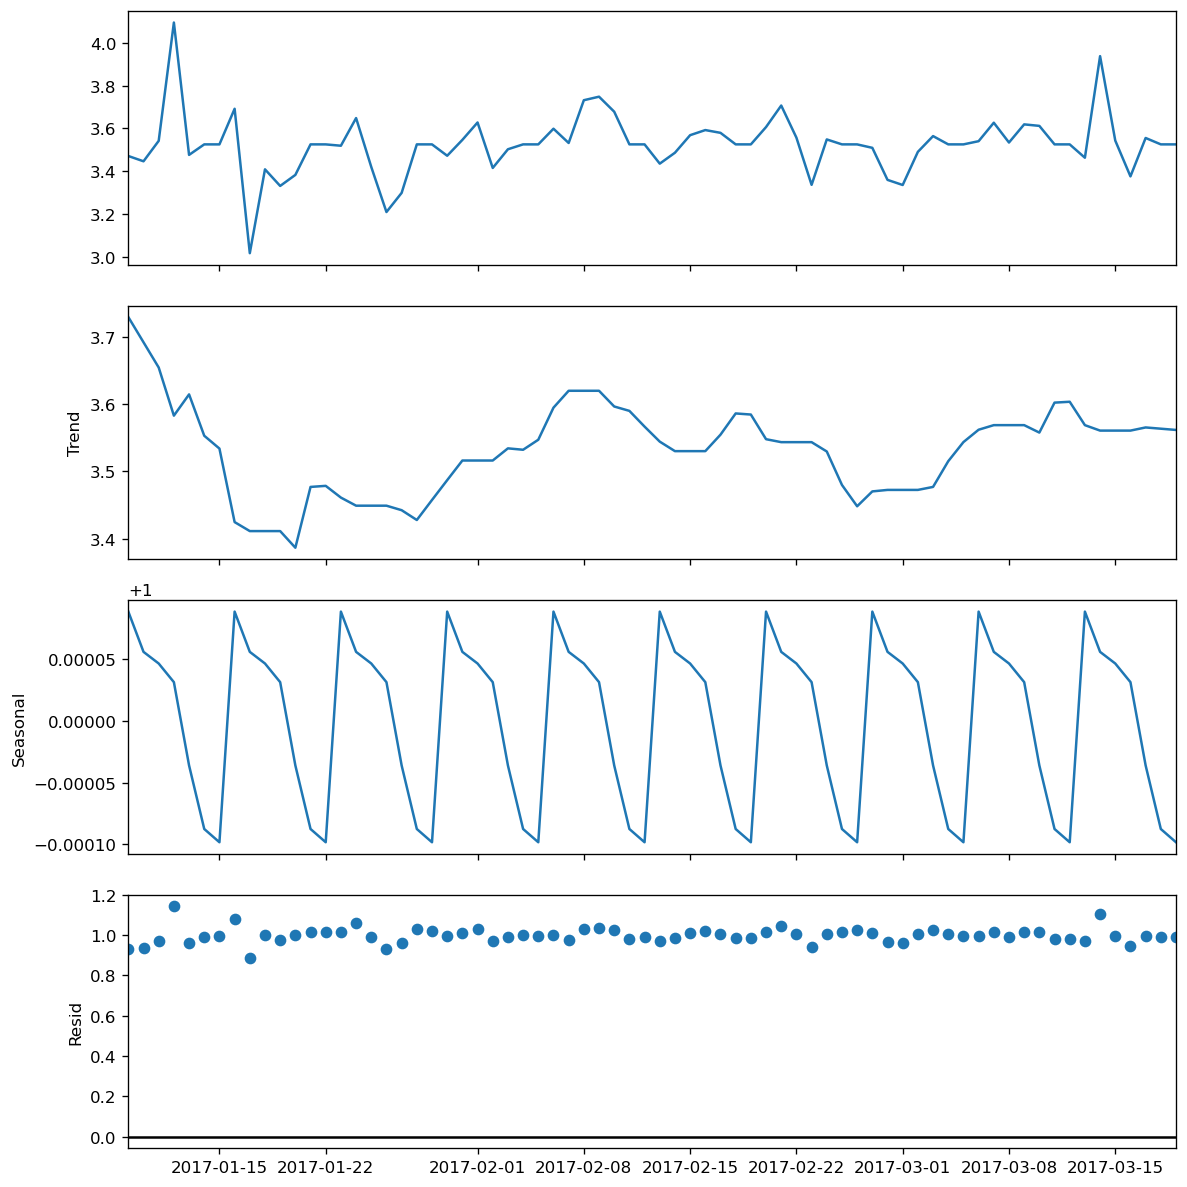

In [52]:
result_add.seasonal

result_add = seasonal_decompose(df.posBalance[:70] / result_add.seasonal, model='multiplicative', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

# Стабилизация Дисперсии (?)

# Изучение ACF/PACF

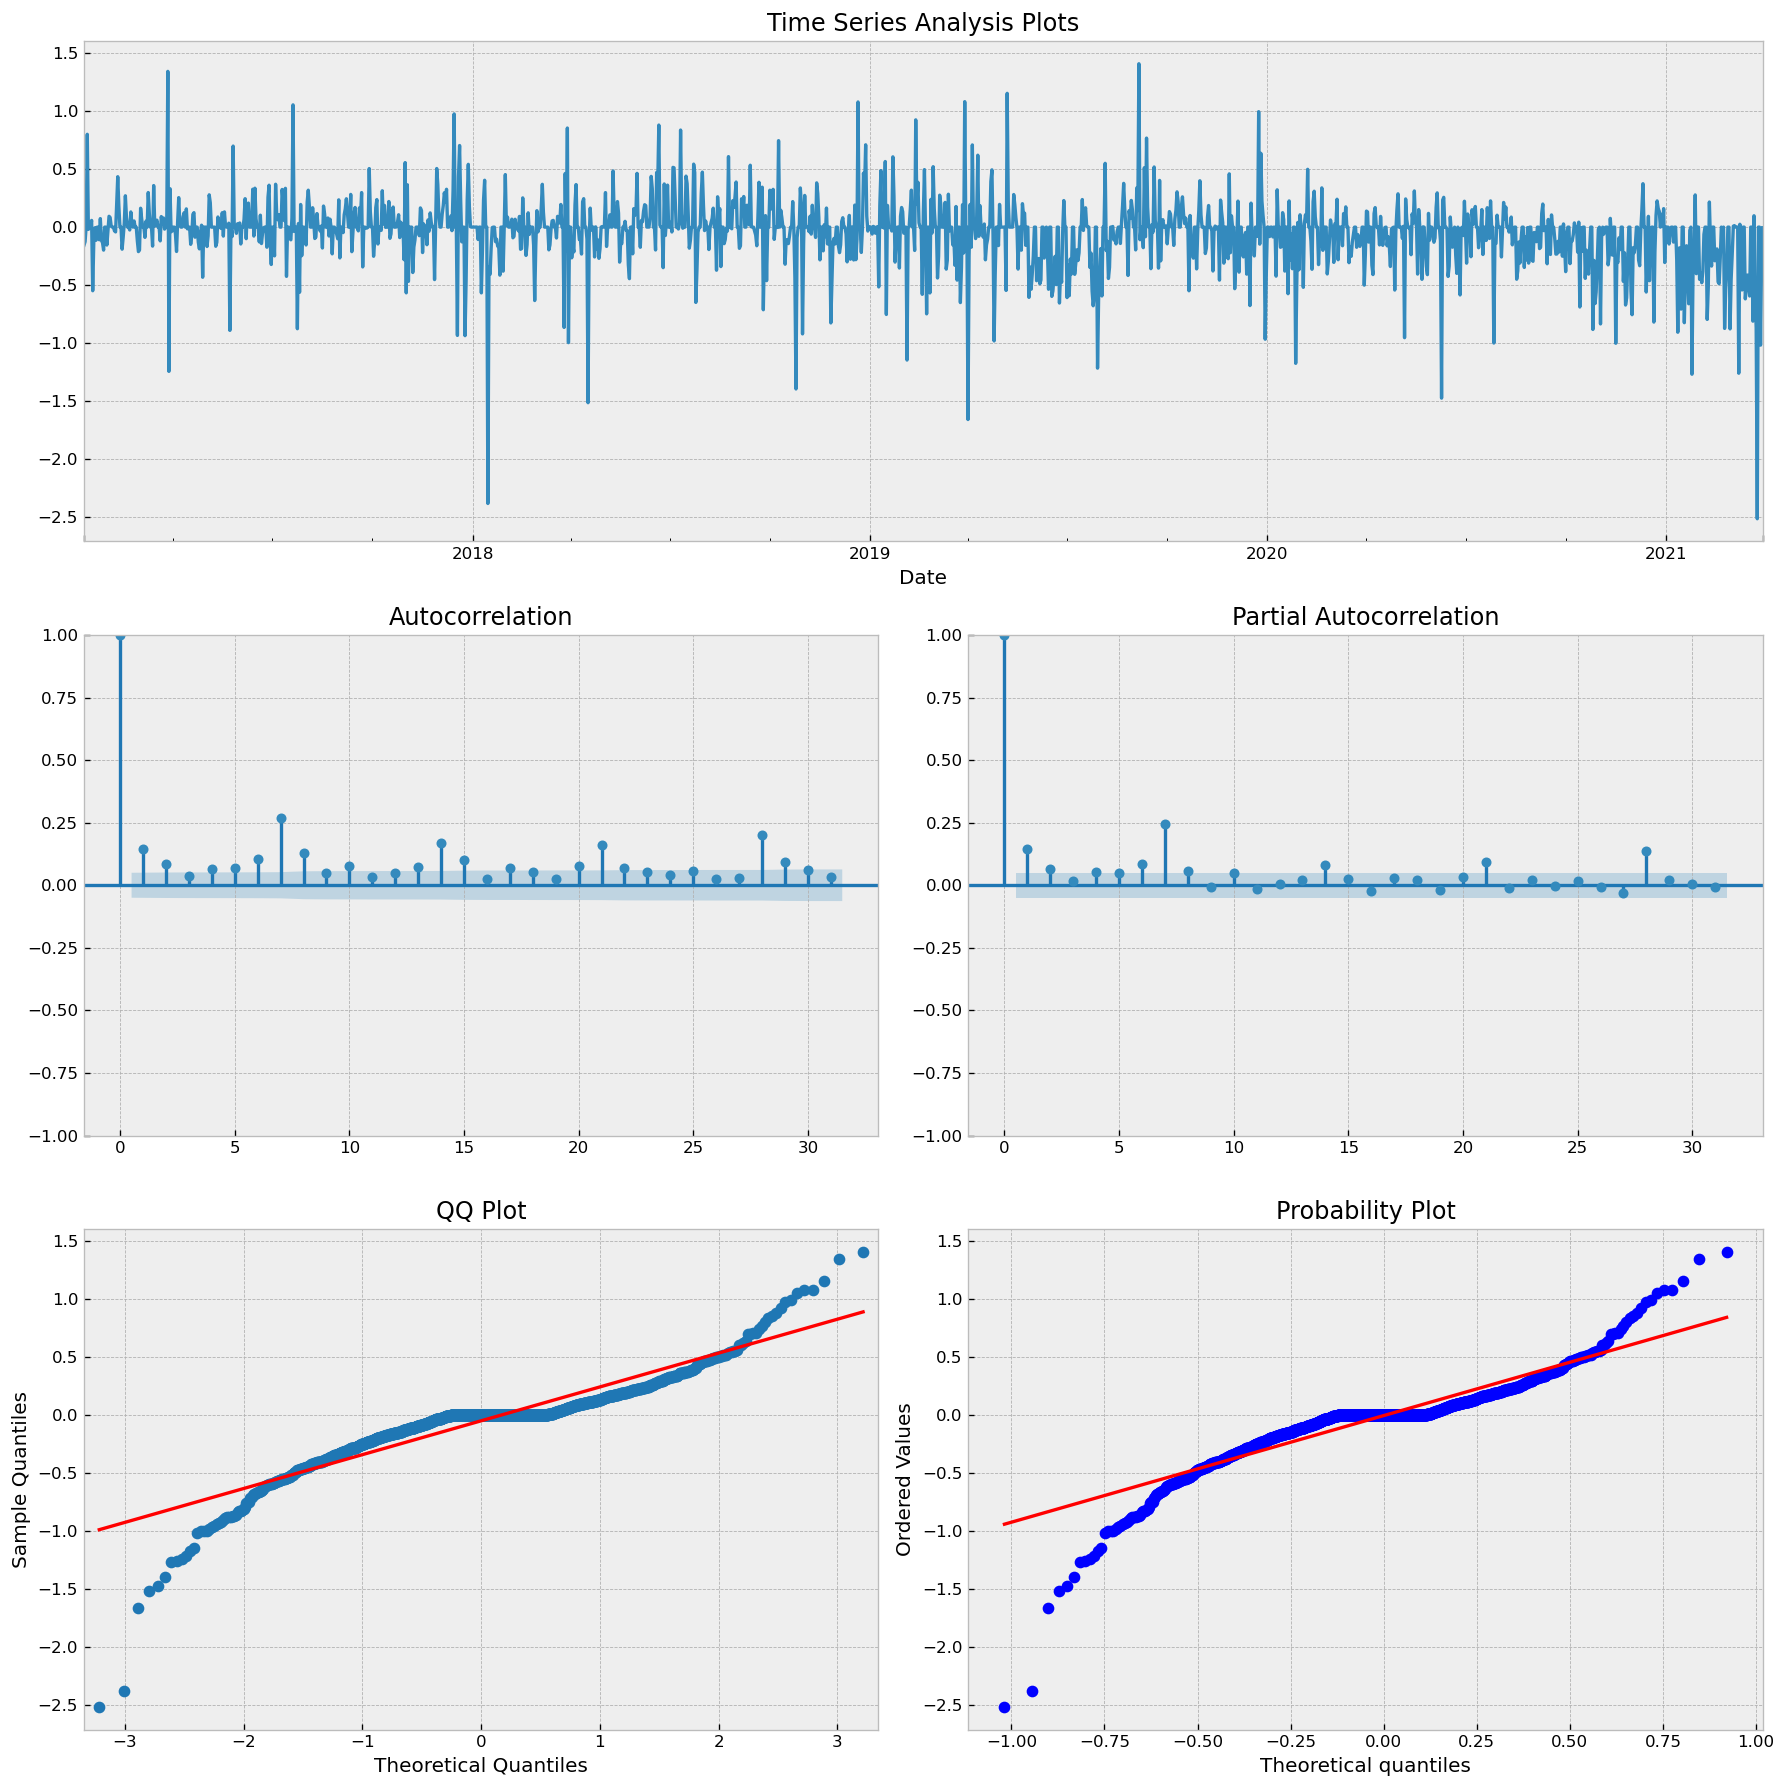

In [11]:
def tsplot(y, lags=None, figsize=(15, 15), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

np.random.seed(1)

# plot of discrete white noise
tsplot(df.Balance, lags=31)

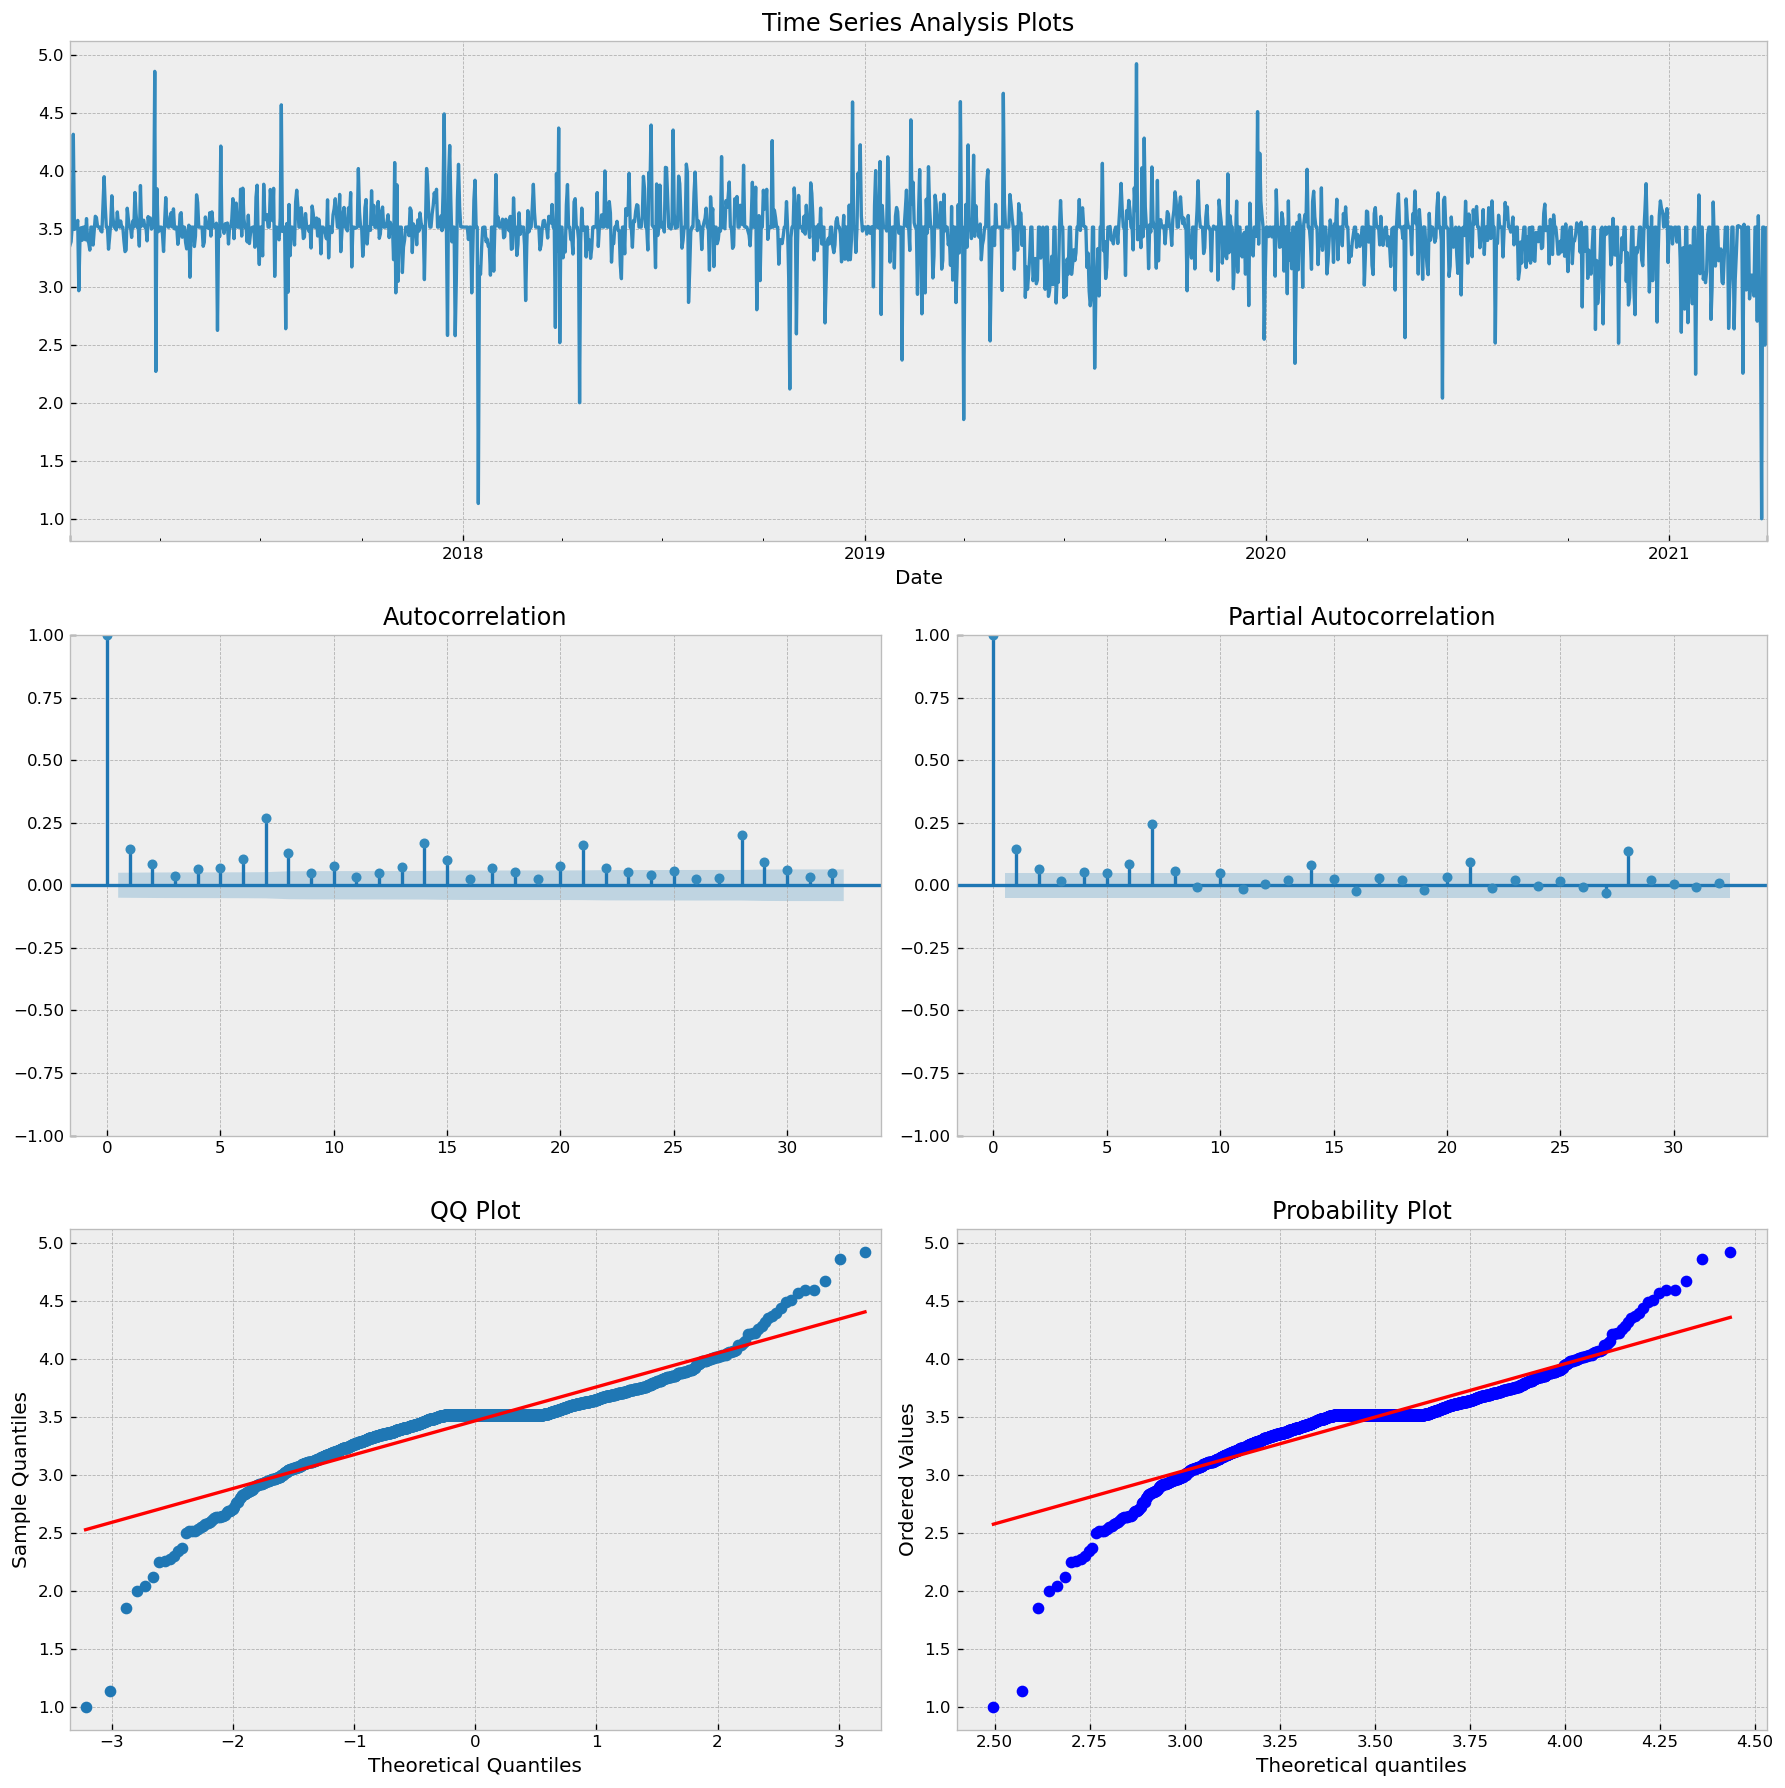

In [53]:
tsplot(df.posBalance)

Похоже на SARIMA(p=1, i=0, q=0, P=1, I=0, Q=0, S=7)

Попробуем избавиться от сезонности дифференцированием

In [12]:
seasonality = 7

df.shift7 = df.posBalance - df.posBalance.shift(7)
df.shift7x2 = df.shift7 - df.shift7.shift(7)

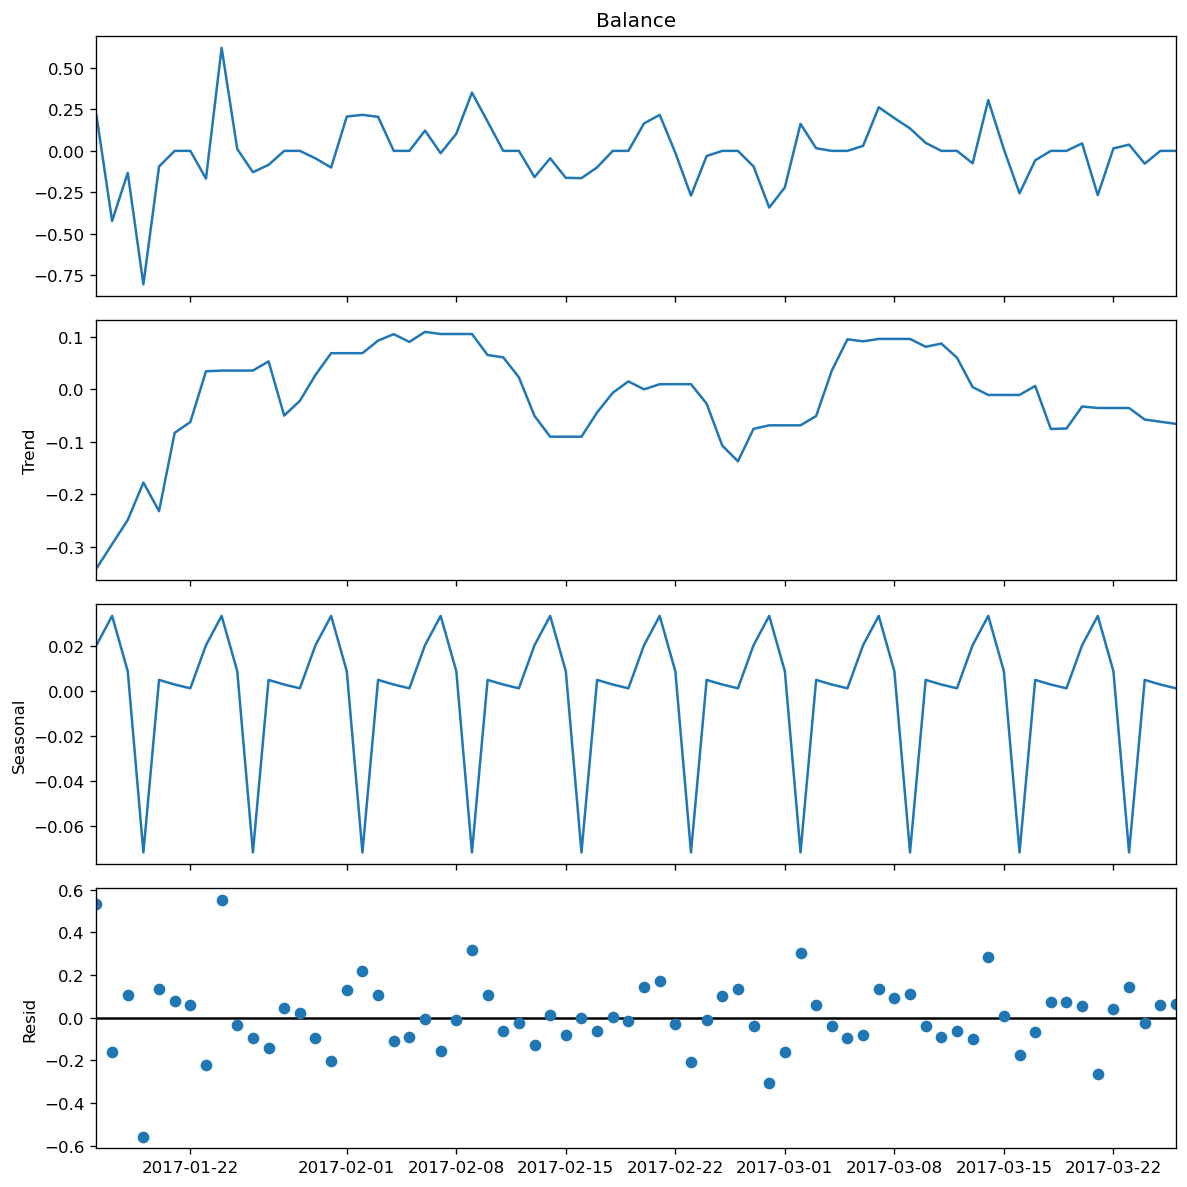

In [32]:
result_add = seasonal_decompose(df.shift7[7:77], model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

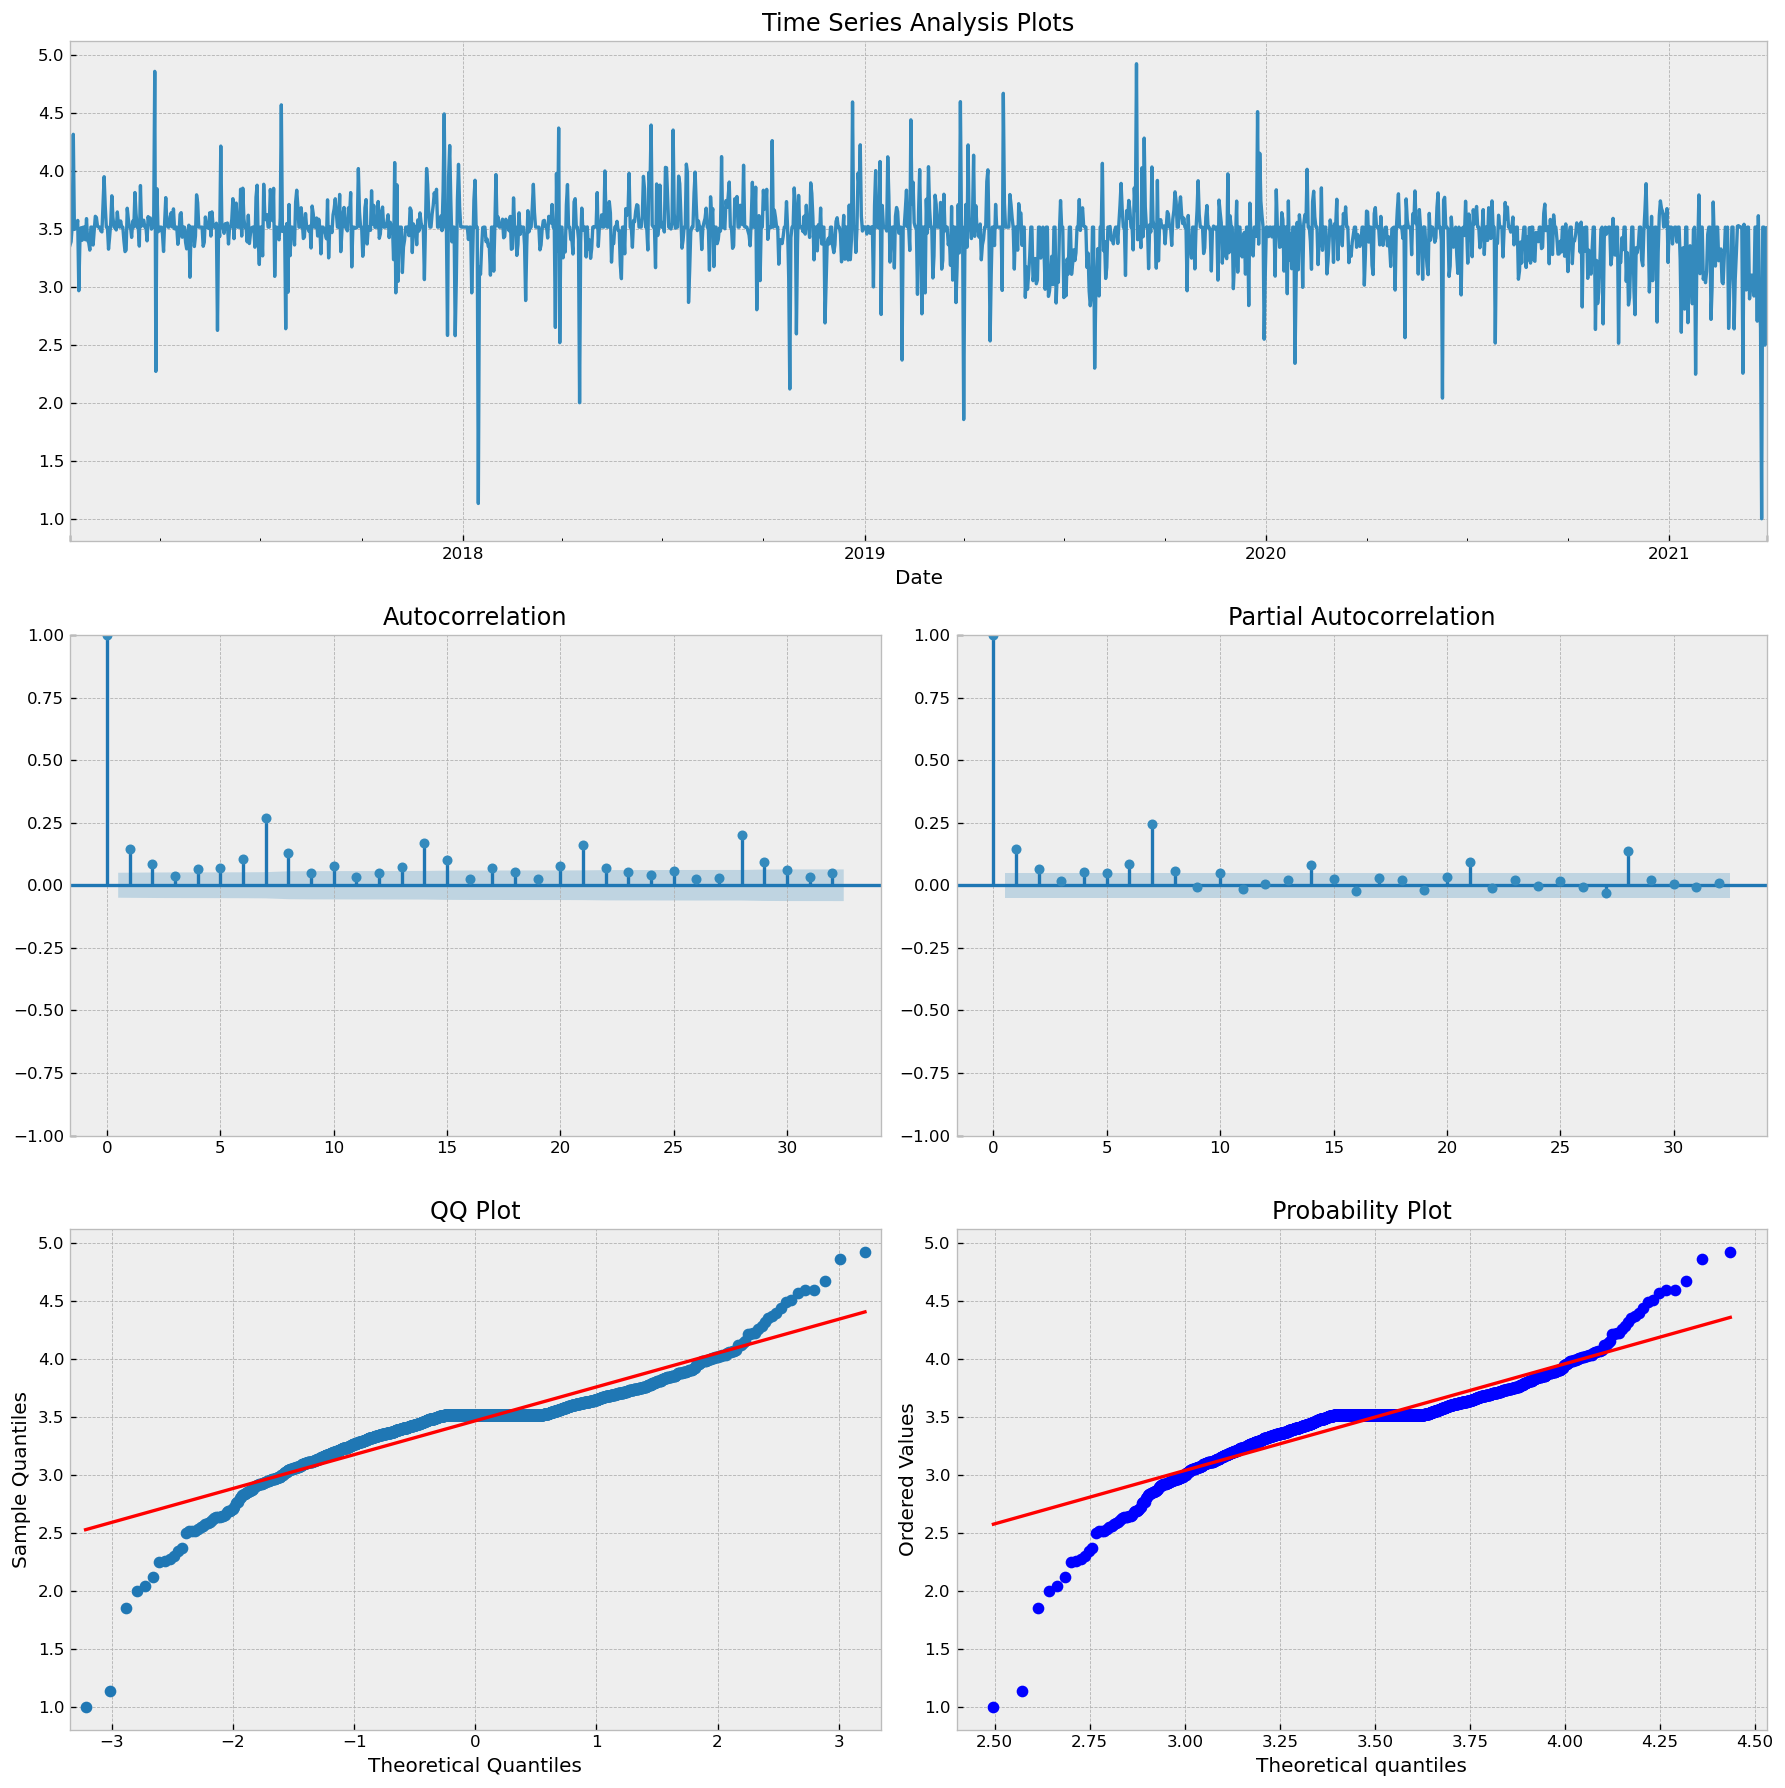

In [107]:
tsplot(df.posBalance)

# Моделирование

In [14]:
start_date = np.datetime64('2017-06-30')
threshold_date = np.datetime64('2019-07-30')
end_date = np.datetime64('2020-07-30')

In [90]:

ps = range(0, 2)
ds = range(0,2)
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

parameters = product(ps, ds, qs, Ps, Qs)
parameters_list = list(parameters)

results = []
best_err = float("inf")
warnings.filterwarnings('ignore')

for combination in parameters_list:
    try:
        model_SARIMAX = ARIMA(endog=df['Balance'], order=(combination[0], combination[1], combination[2]), seasonal_order=(combination[3],1, combination[4], 7))
        model_SARIMAX = model_SARIMAX.fit(df.Balance[df.index < start_date])
    except ValueError:
        print('wrong parameters:', combination)
        continue
    mask = (df.index >= threshold_date) & (df.index <= end_date)
    predict=best_model.predict(start=threshold_date, end=end_date)
    err = (df.Balance[mask]-predict).abs().max()
    if err < best_err:
        best_model = model_SARIMAX
        best_err = err
        best_combination = combination
    results.append([combination, err])

wrong parameters: (0, 0, 0, 1, 0)
wrong parameters: (0, 1, 0, 1, 0)
wrong parameters: (1, 0, 1, 1, 1)
wrong parameters: (1, 1, 1, 1, 1)


In [91]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'err']
display(result_table.sort_values(by='err', ascending=True))

,parameters,err
0,"(0, 0, 0, 0, 0)",1.444685
1,"(0, 0, 0, 0, 1)",NaN
2,"(0, 0, 0, 1, 1)",NaN
3,"(0, 0, 1, 0, 0)",NaN
4,"(0, 0, 1, 0, 1)",NaN
5,"(0, 0, 1, 1, 0)",NaN
6,"(0, 0, 1, 1, 1)",NaN
7,"(0, 1, 0, 0, 0)",NaN
8,"(0, 1, 0, 0, 1)",NaN
9,"(0, 1, 0, 1, 1)",NaN


In [95]:
model_SARIMAX = ARIMA(endog=df['Balance'], order=(1, 1, 1), seasonal_order=(1,1, 1, 7))
model_SARIMAX = model_SARIMAX.fit(df.Balance[df.index < start_date])

In [98]:
predict=model_SARIMAX.predict(start=threshold_date, end=end_date)
predict

2019-07-30   -0.238442
2019-07-31   -0.292527
2019-08-01   -0.255221
2019-08-02   -0.234838
2019-08-03   -0.221736
                ...   
2020-07-26    0.014569
2020-07-27   -0.239396
2020-07-28   -0.163298
2020-07-29   -0.056231
2020-07-30    0.013653
Freq: D, Name: predicted_mean, Length: 367, dtype: float64

In [99]:
mask = (df.index >= threshold_date) & (df.index <= end_date)

<Axes: xlabel='Date', ylabel='predicted_mean'>

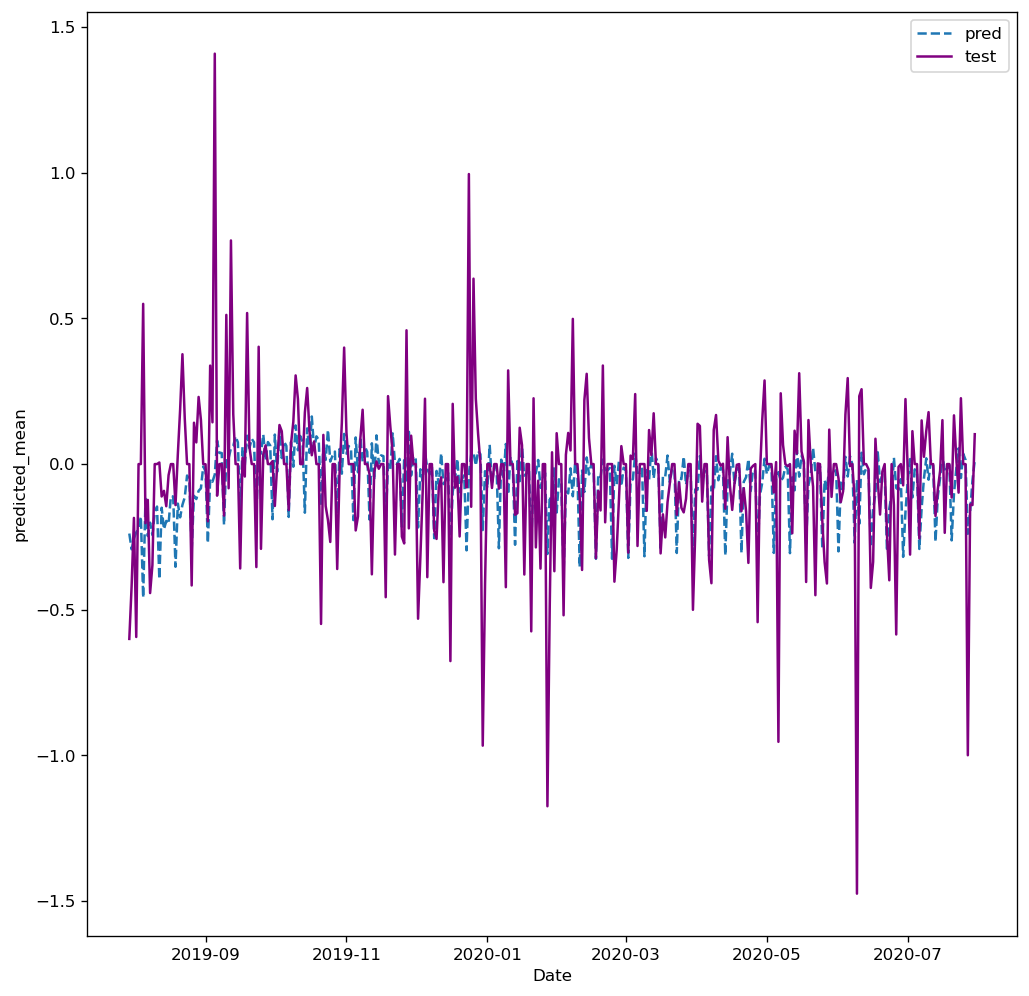

In [106]:
# sns.lineplot(y=df.Balance[df.index < threshold_date], x=df.index[df.index < threshold_date], label='train')
sns.lineplot(x=df.index[mask], y=predict, label='pred', linestyle='dashed')
sns.lineplot(x=df.index[mask], y=df.Balance[mask], label='test', color = 'purple')

In [101]:
err = (df.Balance[mask]-predict).abs()
print(err.max(), err.mean())

1.4446845318803798 0.16022205931530328


<Axes: xlabel='Date'>

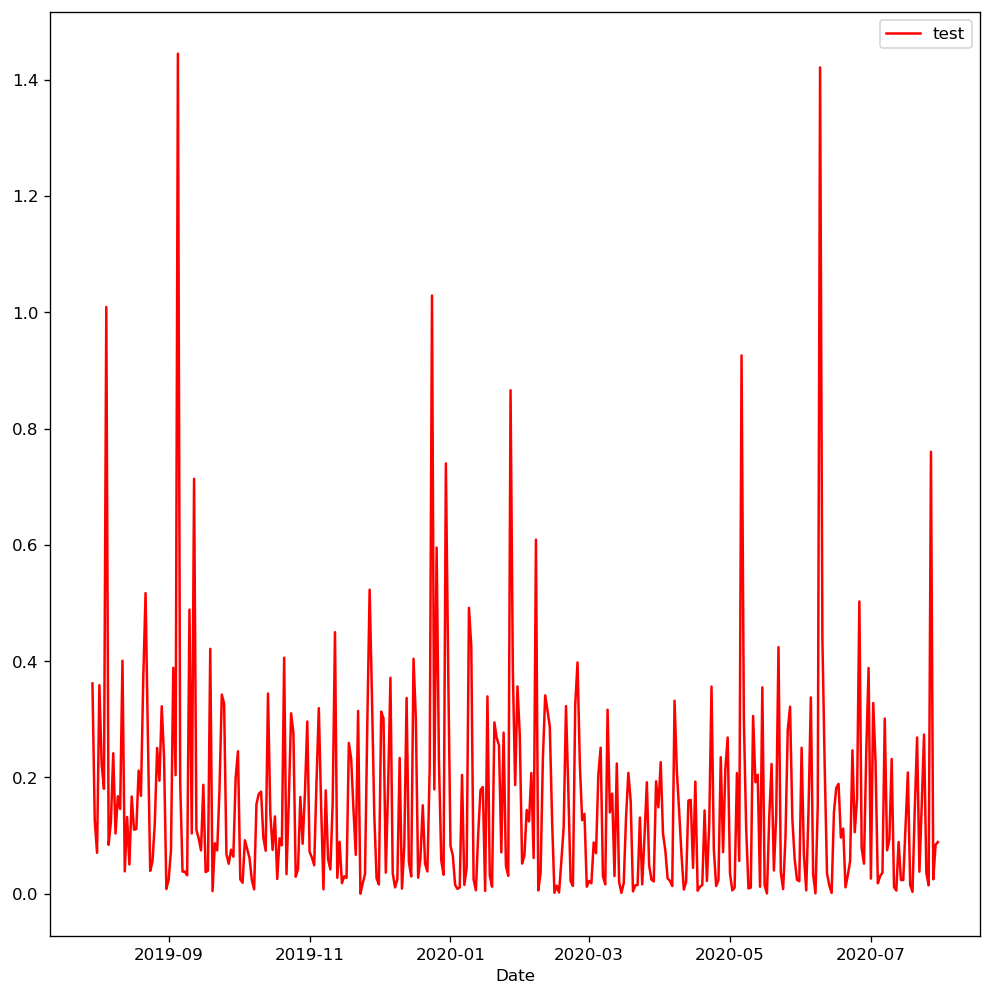

In [102]:
sns.lineplot(x=df.index[mask], y=(df.Balance[mask]-predict).abs(), label='test', color = 'red')